In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_177337/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)


In [3]:


def take_rmse_average_at_level_and_variable(level_in_speedy,variable_speedy):
    # Define: Initial FILES, dates, Variable, and Level desired

    analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'
    
    analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_original_weights_20110101_20120101/mean_output/out.nc'
    
    anal_era5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_3_6hr_timestep_1_24_24_20110101_20120101/mean_output/out.nc'
    
    hybrid_2nd_iter_anal_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_1_3_original_weights_mem1fixed_20110101_20120501/mean_output/out.nc'
    
    hybrid_1_9_1_3_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_3_mem1_fixed_blowup/mean_output/analysis_mean_20110101_20120501.nc'
    
    speedy_1_9_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_1_9_uniform_20110101_20110501/mean.nc'
    
    start_year = 2011
    end_year = 2011

    startdate = datetime(2011,1,1,0)
    enddate = datetime(2011,5,1,0)
    time_slice = slice(startdate,enddate)

    #level = 0.95 #0.2#0.95#0.51
    #level_era = 7 #2#7 #4

    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .835:
        level_in_era = 6
    if level_in_speedy == .685:
        level_in_era = 5
    if level_in_speedy == .51:
        level_in_era = 4
    if level_in_speedy == .34:
        level_in_era = 3
    if level_in_speedy == .2:
        level_in_era = 2
    if level_in_speedy == .095:
        level_in_era = 1
    if level_in_speedy == .025:
        level_in_era = 0
#     print(level_in_era)    
    level_era = level_in_era

    var_da = variable_speedy
    
    
    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
#     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    timestep_6hrly = 6


    # create empty list to store indiviudal datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')

    # loop over the range of years and open each ds
    for year in range(start_year, end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        # only load var_era selected and only load level_era selected from above
        ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
        # Read in every 6th timestep
        ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
        era5sets.append(ds_nature)

    print('Now its concatinating them all together...')

    ds_nature = xr.concat(era5sets, dim = 'Timestep')
    ds_nature = ds_nature.sortby('Timestep')
    print('Done concat and sortby Timestep...')
    temp_500_nature = ds_nature.values

    ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
    ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

    # add ERA5
    ds_era5trained_anal_mean = xr.open_dataset(anal_era5_file)[var_da].sel(lev=level,time=time_slice)
    
    #2nd iter
    ds_2nditer_hybrid = xr.open_dataset(hybrid_2nd_iter_anal_file)[var_da].sel(lev=level,time=time_slice)
    
    # hybrid 1.9,1.3
    ds_hybrid_1_9_1_3 = xr.open_dataset(hybrid_1_9_1_3_file)[var_da].sel(lev=level,time=time_slice)
    
    #speedy 1_9
    ds_speedy_1_9 = xr.open_dataset(speedy_1_9_file)[var_da].sel(lev=level,time=time_slice)
    
    temp_500_analysis = ds_analysis_mean

    # temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
    temp_500_analysis_speedy = ds_analysis_mean_speedy
    # temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
    # temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
    # temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values



    print('era5 shape = ',np.shape(temp_500_nature))
    print('speedy shape = ',np.shape(temp_500_analysis_speedy))
    print('hybrid shape = ',np.shape(temp_500_analysis))

    #find smallest index value to set that as the "length"
    speedy_index = temp_500_analysis_speedy.shape[0]
    nature_index = temp_500_nature.shape[0]
    hybrid_index = temp_500_analysis.shape[0]
    hybrid_2ndindex = ds_2nditer_hybrid.shape[0]
    
    smallest_index = min(speedy_index,nature_index,hybrid_index,hybrid_2ndindex)

    if smallest_index == speedy_index:
        length = speedy_index #- 1
    elif smallest_index == nature_index:
        length = nature_index
    elif smallest_index == hybrid_index:
        length = hybrid_index
    else:
        length = hybrid_2ndindex
        
    print('the smallest length is',length)

    #ps_nature = ds_nature['logp'].values
    #ps_nature = 1000.0 * np.exp(ps_nature)
    #ps_analysis = ds_analysis_mean['ps'].values/100.0

    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    analysis_rmse = np.zeros((length))
    analysis_rmse_speedy = np.zeros((length))
    # global_average_ensemble_spread_hybrid = np.zeros((length))
    # global_average_ensemble_spread_speedy = np.zeros((length))
    #ps_rmse = np.zeros((length))
    anal_rmse_era5trained = np.zeros((length))
    anal_rmse_hybrid_2nd_iter = np.zeros((length))
    anal_rmse_hybrid_1_9_1_3 = np.zeros((length))
    anal_rmse_speedy_1_9 = np.zeros((length))
    
    
    analysis_error = np.zeros((length,ygrid,xgrid))
    analysis_error_speedy = np.zeros((length,ygrid,xgrid))

    print(np.shape(analysis_error))
    print(np.shape(analysis_error_speedy))

    print('Now its calculating analysis RMSE...')
    lats = ds_nature.Lat
    for i in range(length):
        analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
        analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        anal_rmse_era5trained[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_era5trained_anal_mean[i,:,:],lats)
        anal_rmse_hybrid_2nd_iter[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_2nditer_hybrid[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_3[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_3[i,:,:],lats)
        anal_rmse_speedy_1_9[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_speedy_1_9[i,:,:],lats)
        
        
        #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
#         analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
#         analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    #     global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
    #     global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

    # print('mean analysis_rmse = ',analysis_rmse)

    print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP')
    ## MAKING AVERAGES
    
    global average_hybrid
    average_hybrid = np.average(analysis_rmse)
    print('average Hybrid ', average_hybrid)
    
    global average_hybrid2iter
    average_hybrid2iter = np.average(anal_rmse_hybrid_2nd_iter)
    print('average hybrid 2nditer', average_hybrid2iter)
    
    global average_speedy
    average_speedy = np.average(analysis_rmse_speedy)
    print('average speedy ', average_speedy)
    
    global average_era5trained
    average_era5trained = np.average(anal_rmse_era5trained)
    print('average_era5trained ', average_era5trained)
    
    global average_hybrid_1_9_1_3
    average_hybrid_1_9_1_3 = np.average(anal_rmse_hybrid_1_9_1_3)
    print('average_hybrid_1_9_1_3', average_hybrid_1_9_1_3)
    
    global average_speedy_1_9
    average_speedy_1_9 = np.average(anal_rmse_speedy_1_9)
    print('average_speedy_1_9', average_speedy_1_9)
    
    print('Done with analysis.')    

In [4]:
# testing

speedy_file_type_list_of_levels = [0.95, 0.835, 0.685, 0.51, 0.34 , 0.2, 0.095, 0.025]
variable_list_speedy = ['q','u','t','v']

average_list_hybrid_q = []    
average_list_speedy_q = []
average_list_hybrid_v = []
average_list_speedy_v = []
average_list_hybrid_t = []    
average_list_speedy_t = []
average_list_hybrid_u = []
average_list_speedy_u = []
average_list_era5trained_q = []
average_list_era5trained_v = []
average_list_era5trained_t = []
average_list_era5trained_u = []
average_list_hybrid_2nditer_q = []
average_list_hybrid_2nditer_v = []
average_list_hybrid_2nditer_t = []
average_list_hybrid_2nditer_u = []
average_list_hybrid_1_9_1_3_q = []
average_list_hybrid_1_9_1_3_v = []
average_list_hybrid_1_9_1_3_t = []
average_list_hybrid_1_9_1_3_u = []
average_list_speedy_1_9_q = []
average_list_speedy_1_9_v = []
average_list_speedy_1_9_u = []
average_list_speedy_1_9_t = []

# loop
for level in speedy_file_type_list_of_levels:
    for variable in variable_list_speedy: 
        take_rmse_average_at_level_and_variable(level,variable)
        
        if variable == 'q':
            average_list_hybrid_q.append(average_hybrid)
            average_list_speedy_q.append(average_speedy)
            average_list_era5trained_q.append(average_era5trained)
            average_list_hybrid_2nditer_q.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_q.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_q.append(average_speedy_1_9)
        elif variable == 'u':
            average_list_hybrid_u.append(average_hybrid)
            average_list_speedy_u.append(average_speedy)
            average_list_era5trained_u.append(average_era5trained)
            average_list_hybrid_2nditer_u.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_u.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_u.append(average_speedy_1_9)
        elif variable == 'v':
            average_list_hybrid_v.append(average_hybrid)
            average_list_speedy_v.append(average_speedy)
            average_list_era5trained_v.append(average_era5trained)
            average_list_hybrid_2nditer_v.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_v.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_v.append(average_speedy_1_9)
        elif variable == 't':
            average_list_hybrid_t.append(average_hybrid)
            average_list_speedy_t.append(average_speedy)
            average_list_era5trained_t.append(average_era5trained)
            average_list_hybrid_2nditer_t.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_t.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_t.append(average_speedy_1_9)
        
            
        print('average list hybrid_q check:', average_list_hybrid_q)
        print('average list speedy_q check:', average_list_speedy_q)
        print('average list era5_q check:', average_list_era5trained_q)
        print('average list hybrid_2nditer_q check:', average_list_hybrid_2nditer_q)
        print('average list hybrid_1_9_1_3_q check:', average_list_hybrid_1_9_1_3_q)
        print('average list speedy_1_9_q check:', average_list_speedy_1_9_q)
        print('average list hybrid_u check:', average_list_hybrid_u)
        print('average list speedy_u check:', average_list_speedy_u)
        print('average list era5_u check:', average_list_era5trained_u)
        print('average list hybrid_2nditer_u check:', average_list_hybrid_2nditer_u)
        print('average list hybrid_1_9_1_3_u check:', average_list_hybrid_1_9_1_3_u)
        print('average list speedy_1_9_u check:', average_list_speedy_1_9_u)
        print('average list hybrid_v check:', average_list_hybrid_v)
        print('average list speedy_v check:', average_list_speedy_v)
        print('average list era5_v check:', average_list_era5trained_v)
        print('average list hybrid_2nditer_v check:', average_list_hybrid_2nditer_v)
        print('average list hybrid_1_9_1_3_v check:', average_list_hybrid_1_9_1_3_v)
        print('average list speedy_1_9_v check:', average_list_speedy_1_9_v)
        print('average list hybrid_t check:', average_list_hybrid_t)
        print('average list speedy_t check:', average_list_speedy_t)
        print('average list era5_t check:', average_list_era5trained_t)
        print('average list hybrid_2nditer_t check:', average_list_hybrid_2nditer_t)
        print('average list hybrid_1_9_1_3_t check:', average_list_hybrid_1_9_1_3_t)
        print('average list speedy_1_9_t check:', average_list_speedy_1_9_t)

        
print('Vertical profile of era5trained hybrid q ', average_list_era5trained_q)
    

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  0.001359125868157869
average hybrid 2nditer 0.0013630029884807906
average speedy  0.0014960612596366981
average_era5trained  0.0007137005274733935
average_hybrid_1_9_1_3 0.0013060017013070396
average_speedy_1_9 0.001329702496278853
Done with analysis.
average list hybrid_q check: [0.001359125868157869]
average list speedy_q check: [0.0014960612596366981]
average list era5_q check: [0.0007137005274733935]
average list hybrid_2nditer_q check: [0.0013630029884807906]
average list hybrid_1_9_1_3_q check: [0.0013060017013070396]
average list

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.7684317566996555
average hybrid 2nditer 2.715129536551398
average speedy  3.065404997546063
average_era5trained  2.17022292108397
average_hybrid_1_9_1_3 2.700233683021054
average_speedy_1_9 2.664926537852773
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714]
average list hybrid_2nditer_q check: [0.0013630029884807906, 0.001369967960351749]
average list hybrid_1_9_1_3_q check: [0.0013060017013070396, 0.001319377737801344]
average list speedy_1_9_q check: [0.001329702496278853, 0.0013254853771426356]
average l

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.7876907698577753
average hybrid 2nditer 2.7257001186854626
average speedy  3.1399285560338264
average_era5trained  2.3549322675518582
average_hybrid_1_9_1_3 2.727527419147769
average_speedy_1_9 2.6474756034644873
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943]
average list hybrid_2nditer_q check: [0.0013630029884807906, 0.001369967960351749, 0.0011119815330224386]
average list hybrid_1_9_1_3_q check: [0.0013060017013070396, 0.00131937773

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  0.0006679696146604022
average hybrid 2nditer 0.0006416648883602956
average speedy  0.0007700322756423709
average_era5trained  0.0005275401535585305
average_hybrid_1_9_1_3 0.0006030436206837485
average_speedy_1_9 0.0006414503560995919
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943, 0.0005275401535585305]
average list hybrid_2nditer_q check: [0.0013630029884807906, 0.001369967960351749, 0.0011119

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  3.3378490400413465
average hybrid 2nditer 3.243798814047895
average speedy  3.7956138217275703
average_era5trained  2.995031459415777
average_hybrid_1_9_1_3 3.2887284012197706
average_speedy_1_9 3.1487469276618563
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943, 0.0005275401535585305]
average list hybrid_2nditer_q check: [0.0013630029884807906, 0.001369967960351749, 0.0011119815330224386, 0.0006

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.4267660557851969
average hybrid 2nditer 1.3609535309975955
average speedy  1.776344740217292
average_era5trained  1.0359099704361756
average_hybrid_1_9_1_3 1.3161694807718796
average_speedy_1_9 1.3406863244804177
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943, 0.0005275401535585305, 0.0001436247845340555]
average list hybrid_2nditer_q check: [0.0

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  3.7932151796416282
average hybrid 2nditer 3.6480741867652307
average speedy  4.539983596226778
average_era5trained  3.182547382406286
average_hybrid_1_9_1_3 3.6907700198603766
average_speedy_1_9 3.7182112181261027
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122, 4.018834684859272e-05]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364, 4.868701675104698e-05]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943, 0.0005275401535585305, 0.00014362478453405

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  3.5805073344534004
average hybrid 2nditer 3.4317482092772105
average speedy  4.360905738977285
average_era5trained  3.1158650263431413
average_hybrid_1_9_1_3 3.51640082198716
average_speedy_1_9 3.481335081330456
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122, 4.018834684859272e-05]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364, 4.868701675104698e-05]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943, 0.0005275401535585305, 0.0001436247845340555

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.6422900395185187
average hybrid 2nditer 2.5899193970924106
average speedy  3.258640945577324
average_era5trained  2.2497831084871986
average_hybrid_1_9_1_3 2.5967485086833615
average_speedy_1_9 2.5923276349065705
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122, 4.018834684859272e-05, 1.5744053298438685e-06]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364, 4.868701675104698e-05, 1.588038793454865e-06]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.000909219805868

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.5396542231902757
average hybrid 2nditer 2.4816805369640833
average speedy  2.760417085179668
average_era5trained  2.222061572352467
average_hybrid_1_9_1_3 2.50288621452395
average_speedy_1_9 2.382342226044304
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122, 4.018834684859272e-05, 1.5744053298438685e-06]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364, 4.868701675104698e-05, 1.588038793454865e-06]
average list era5_q check: [0.0007137005274733935, 0.0010682856499482714, 0.0009092198058685943

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  4.319425789581267
average hybrid 2nditer 4.0764155893464595
average speedy  5.588185200324426
average_era5trained  5.421365212006282
average_hybrid_1_9_1_3 4.172399671558531
average_speedy_1_9 4.6493525282013195
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122, 4.018834684859272e-05, 1.5744053298438685e-06, 1.871380971109727e-06]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364, 4.868701675104698e-05, 1.588038793454865e-06, 1.871380971109727e-06]
average list era5_q check: [0.000713700527473393

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (481, 48, 96)
hybrid shape =  (481, 48, 96)
the smallest length is 481
(481, 48, 96)
(481, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  3.0316438838498754
average hybrid 2nditer 3.024505702472774
average speedy  3.4295729549907596
average_era5trained  2.6329539632598973
average_hybrid_1_9_1_3 3.062474409408728
average_speedy_1_9 3.150411822939613
Done with analysis.
average list hybrid_q check: [0.001359125868157869, 0.0013969446118076848, 0.0012118746739523698, 0.0006679696146604022, 0.0002733739093551122, 4.018834684859272e-05, 1.5744053298438685e-06, 1.871380971109727e-06]
average list speedy_q check: [0.0014960612596366981, 0.001585125823925383, 0.0015323953202048513, 0.0007700322756423709, 0.00029225899394274364, 4.868701675104698e-05, 1.588038793454865e-06, 1.871380971109727e-06]
average list era5_q check: [0.00071370052747339

In [5]:
# convert to g/kg
average_list_era5trained_q_g_kg = [i * 1000 for i in average_list_era5trained_q]
average_list_hybrid_q_g_kg = [i * 1000 for i in average_list_hybrid_q]
average_list_speedy_q_g_kg = [i * 1000 for i in average_list_speedy_q]
average_list_hybrid2nditer_q_g_kg = [i * 1000 for i in average_list_hybrid_2nditer_q]
average_list_hybrid_1_9_1_3_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_3_q]
average_list_speedy_1_9_q_g_kg = [i * 1000 for i in average_list_speedy_1_9_q]

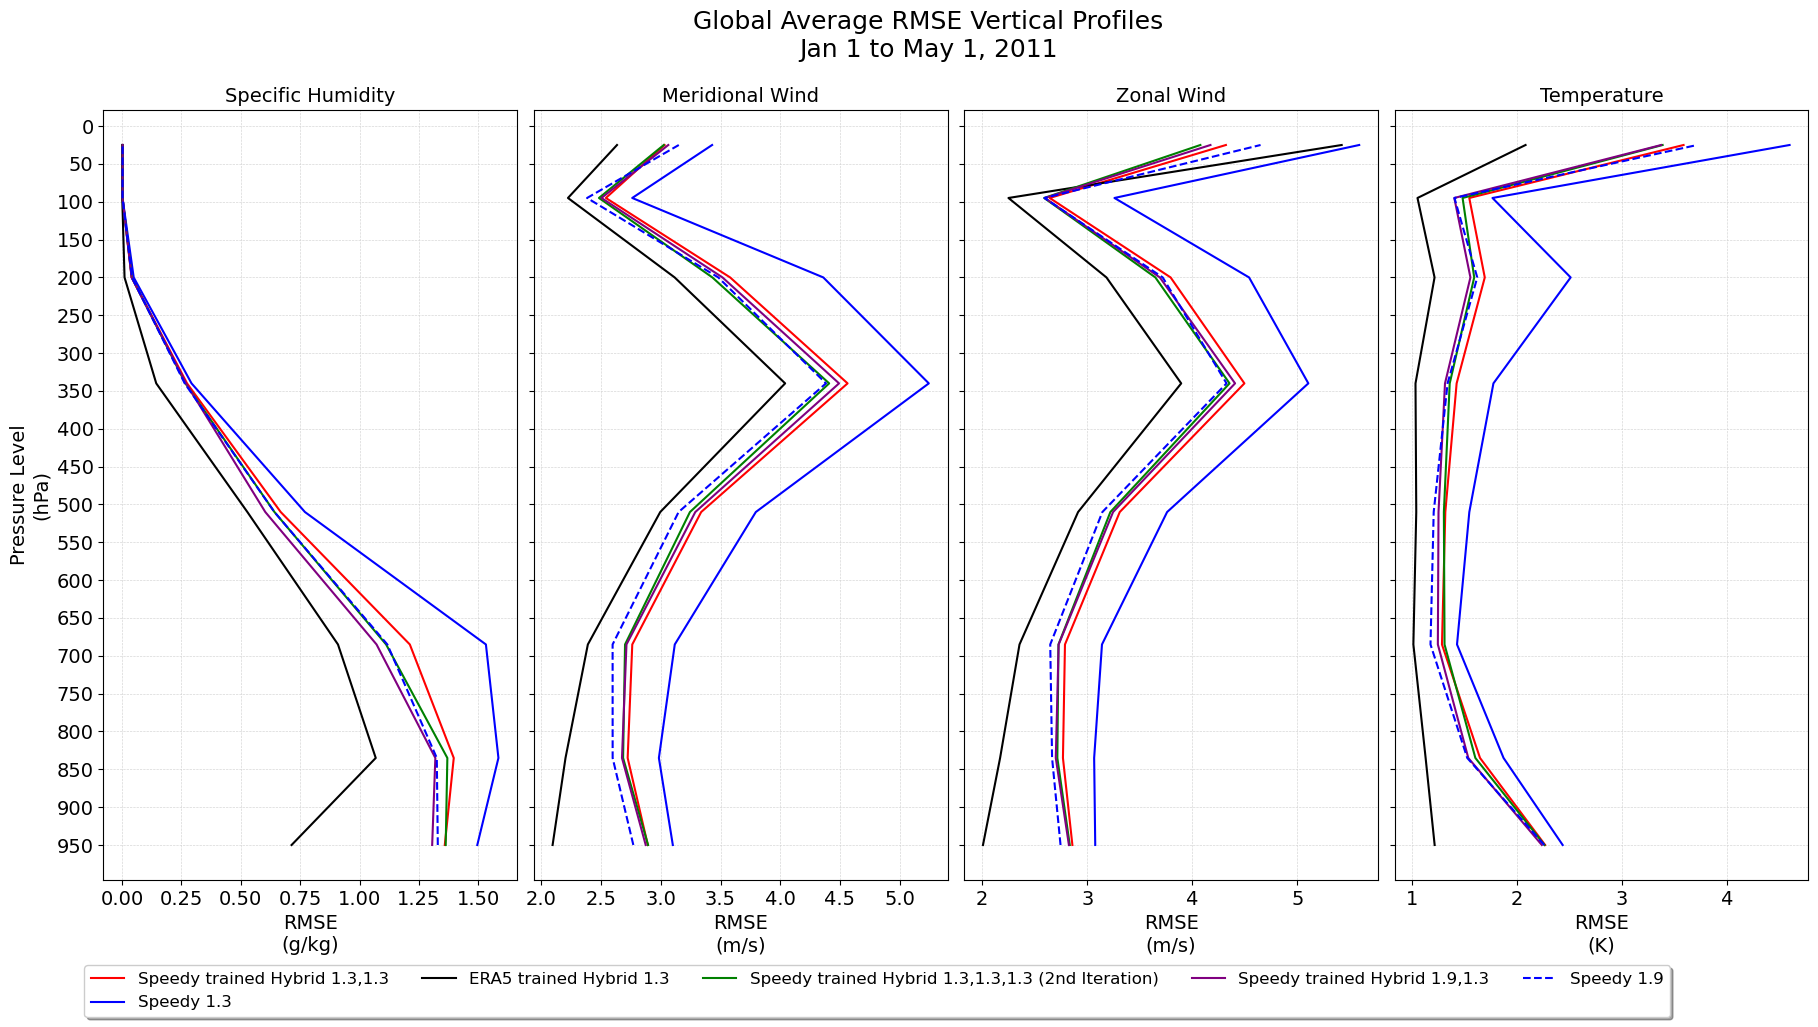

In [11]:
# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(22, 10), sharey=True)

# y-axis is height (in hPa)
y_axis = [1000 * i for i in speedy_file_type_list_of_levels]
plt.gca().invert_yaxis()

# Set y-ticks
plt.yticks(np.arange(0, 1000, 50))
i = 0
# for i in range(0,4,1):
while i < 4:
    axs[i].grid(color='lightgrey', linestyle='--', linewidth=0.45)
    i += 1
    
fontsize_select = 14 

plt.suptitle('Global Average RMSE Vertical Profiles\nJan 1 to May 1, 2011',fontsize=18)
# Plot for 'q'
axs[0].plot(average_list_hybrid_q_g_kg, y_axis, color='red')
axs[0].plot(average_list_speedy_q_g_kg, y_axis, color='blue')
axs[0].plot(average_list_era5trained_q_g_kg,y_axis,color='black')
axs[0].plot(average_list_hybrid2nditer_q_g_kg, y_axis,color='green')
axs[0].plot(average_list_hybrid_1_9_1_3_q_g_kg,y_axis,color = 'purple')
axs[0].plot(average_list_speedy_1_9_q_g_kg, y_axis, color = 'blue', linestyle = 'dashed')
axs[0].set_title('Specific Humidity',fontsize = fontsize_select)
axs[0].set_xlabel('RMSE\n(g/kg)',fontsize = fontsize_select)
axs[0].set_ylabel('Pressure Level\n(hPa)',fontsize = fontsize_select)
for ax in axs:
    ax.tick_params(axis='y', labelsize=fontsize_select)  # Set the font size to 12

# Plot for 'v'
axs[1].plot(average_list_hybrid_v, y_axis, color='red')
axs[1].plot(average_list_speedy_v, y_axis, color='blue')
axs[1].plot(average_list_era5trained_v,y_axis,color='black')
axs[1].plot(average_list_hybrid_2nditer_v, y_axis,color='green')
axs[1].plot(average_list_hybrid_1_9_1_3_v,y_axis,color = 'purple')
axs[1].plot(average_list_speedy_1_9_v, y_axis, color = 'blue', linestyle = 'dashed')
axs[1].set_title('Meridional Wind',fontsize = fontsize_select)
axs[1].set_xlabel('RMSE\n(m/s)',fontsize = fontsize_select)
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize_select)
# Plot for 'u'
axs[2].plot(average_list_hybrid_u, y_axis, color='red')
axs[2].plot(average_list_speedy_u, y_axis, color='blue')
axs[2].plot(average_list_era5trained_u,y_axis,color='black')
axs[2].plot(average_list_hybrid_2nditer_u, y_axis,color='green')
axs[2].plot(average_list_hybrid_1_9_1_3_u,y_axis,color = 'purple')
axs[2].plot(average_list_speedy_1_9_u, y_axis, color = 'blue', linestyle = 'dashed')
axs[2].set_title('Zonal Wind',fontsize = fontsize_select)
axs[2].set_xlabel('RMSE\n(m/s)',fontsize = fontsize_select)
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize_select)
# Plot for 't'
axs[3].plot(average_list_hybrid_t, y_axis, color='red', label = "Speedy trained Hybrid 1.3,1.3")
axs[3].plot(average_list_speedy_t, y_axis, color='blue', label= 'Speedy 1.3')
axs[3].plot(average_list_era5trained_t,y_axis,color='black',label = "ERA5 trained Hybrid 1.3")
axs[3].plot(average_list_hybrid_2nditer_t, y_axis,color='green',label= 'Speedy trained Hybrid 1.3,1.3,1.3 (2nd Iteration)')
axs[3].plot(average_list_hybrid_1_9_1_3_t,y_axis,color = 'purple',label='Speedy trained Hybrid 1.9,1.3')
axs[3].plot(average_list_speedy_1_9_t, y_axis, color = 'blue', linestyle = 'dashed', label='Speedy 1.9')
axs[3].set_title('Temperature',fontsize = fontsize_select)
axs[3].set_xlabel('RMSE\n(K)',fontsize = fontsize_select)
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize_select)

# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(-1.25, -0.1), fancybox=True, shadow=True, ncol=5, fontsize = 'large')
plt.subplots_adjust(wspace=0.04)
# plt.savefig('Global_RMSE_Vertical_Profiles_4_22_24.png',bbox_inches='tight', dpi=1200)
plt.show()

In [7]:
average_list_speedy_1_9_q


[0.001329702496278853,
 0.0013254853771426356,
 0.0011171613359560496,
 0.0006414503560995919,
 0.0002635012386768975,
 4.140496450887069e-05,
 1.5875135250476707e-06,
 1.871380971109727e-06]